In [2]:
import matplotlib.pyplot as plt
import numpy as np
# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle')
font = {'size'   : 16}
plt.rc('font', **font)

In [3]:
def parseTiming(fname):
    with open(fname, 'r') as f:
        for line in f:
            if "diverged" in line: raise Exception(f"iterations in file {fname} diverged!")
            if "Braid" in line: continue
            if "wall time" in line: return float(line.split()[-1])

def parseTol(fname, tol):
    with open(fname, 'r') as f:
        for line in f:
            if "diverged" in line: raise Exception(f"iterations in file {fname} diverged!")
            if "Begin" in line: continue
            if "not available" in line: continue
            if "Solver Stats" in line: continue
            if "Braid" in line and "wall time" in line:
                res = float(line.split()[5].split(',')[0])
                if res <= tol:
                    return float(line.split()[-1])

def parseIters(fname):
    with open(fname, 'r') as f:
        for line in f:
            if "max iterations" in line: continue
            if "Max" in line: continue
            if "iterations" in line: return float(line.split()[-1])

In [15]:
ncores = (16, 32, 64, 128, 256, 512, 1024)
mlevels = (4, 4, 4, 4, 4, 4, 4)
thetas = np.zeros(len(ncores))
deltas = np.zeros(len(ncores))
mgrits = np.zeros(len(ncores))
bad_pts = []
tol = 1e-6

serial = parseTiming("ks_ml1")

for i, (nc, ml) in enumerate(zip(ncores, mlevels)):
    thetas[i] = parseTol(f"ks_theta_nc{nc}_cf4_ml{ml}", tol)
    if np.isnan(thetas[i]):
        thetas[i] = parseTiming(f"ks_theta_nc{nc}_cf4_ml{ml}")
        bad_pts.append((nc, thetas[i]))

for i, (nc, ml) in enumerate(zip(ncores, mlevels)):
    deltas[i] = parseTol(f"ks_Delta10_nc{nc}_cf4_ml{ml}", tol)
    if np.isnan(deltas[i]):
        deltas[i] = parseTiming(f"ks_Delta10_{nc}_cf4_ml{ml}")
        bad_pts.append((nc, deltas[i]))

for i, (nc, ml) in enumerate(zip(ncores, mlevels)):
    mgrits[i] = parseTol(f"ks_nc{nc}_cf4_ml{ml}", tol)
    if np.isnan(mgrits[i]):
        mgrits[i] = parseTiming(f"ks_nc{nc}_cf4_ml{ml}")
        bad_pts.append((nc, mgrits[i]))

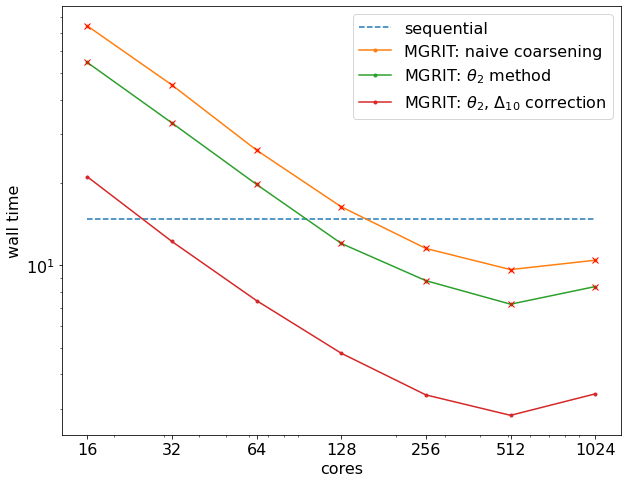

In [16]:
fig, ax = plt.subplots(figsize=(9,7))
ax.loglog(ncores, serial*np.ones(len(ncores)), '--', label="sequential")
ax.loglog(ncores, mgrits, '.-', label="MGRIT: naive coarsening")
ax.loglog(ncores, thetas, '.-', label=r"MGRIT: $\theta_2$ method")
ax.loglog(ncores, deltas, '.-', label=r"MGRIT: $\theta_2$, $\Delta_{10}$ correction")
[ax.plot(*pt, 'rx') for pt in bad_pts]
ax.set_xlabel("cores")
ax.set_ylabel("wall time")
ax.legend()
plt.xticks(ncores, ncores)
plt.tight_layout()
plt.savefig("weak_scaling_KS_128.png", dpi=300)

[(16, 54.750878),
 (32, 32.960843),
 (64, 19.684556),
 (128, 12.000204),
 (256, 8.782001),
 (512, 7.21151),
 (1024, 8.35901),
 (16, 74.394171),
 (32, 45.305672),
 (64, 26.233519),
 (128, 16.316111),
 (256, 11.505576),
 (512, 9.63764),
 (1024, 10.426521)]

In [18]:
thetas

array([54.750878, 32.960843, 19.684556, 12.000204,  8.782001,  7.21151 ,
        8.35901 ])

In [19]:
deltas

array([21.  , 12.2 ,  7.43,  4.78,  3.37,  2.84,  3.4 ])

In [20]:
serial

14.712374